# Tessellations network + Boeing network join

The Boeing network is a more simplified version of the OSMnx network. However, the Tessellations network covers zones that the Boeing network doesn't.

This notebook explores a way to join to __expand couverture in uncovered zones__ by joining parts of the OSMnx network to the Boeing network.

## Import libraries

In [1]:
accesibilidad_urbana = "../../../"

In [358]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# To create Point from coordinates
from shapely import Point
# For calculate distance between points
import math
# To know if it is a LineString or a MultiLineString, and create them
from shapely.geometry import LineString, MultiLineString
# To split a line using a point in that line
from shapely.ops import split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(accesibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [10]:
# Projection to be used whenever necessary
projected_crs = "EPSG:32618"

# Save plots in output > figures > volvo > networks_join
save_plots = True
savefig_dir = accesibilidad_urbana+"output/figures/volvo/networks_join/"

# Boeing input network
boeing_nodes_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp"
boeing_edges_dir = accesibilidad_urbana+ "data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp"

# OSMnx input network
tess_nodes_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg" #From ntbk 06.
tess_edges_dir = accesibilidad_urbana+ "data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg" #From ntbk 06.

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_nodes.shp
../../../data/external/volvo/input_boeing_network/moravia_LH_boeing_edges.shp
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_nodes_f.gpkg
../../../data/external/volvo/output_tessellations_network/moravia_LH_tessellations_edges_f.gpkg


## Input data

### __Input data__ - Boeing network

In [4]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32618
(743, 2)


,osmid,geometry
0,344191636,POINT (437449.345 692995.293)
1,344191639,POINT (437370.198 692566.062)


In [5]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32618
(1077, 4)


,u,v,key,geometry
0,344191636,344297704,0,"LINESTRING (437449.345 692995.293, 437415.442 ..."
1,344191636,429632637,0,"LINESTRING (437449.345 692995.293, 437544.786 ..."


### __Input data__ - Tessellations network

In [6]:
# Load nodes data
tess_nodes = gpd.read_file(tess_nodes_dir)

# Set CRS
if tess_nodes.crs != projected_crs:
    try:
        tess_nodes = tess_nodes.set_crs(projected_crs)
    except:
        tess_nodes = tess_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(tess_nodes.columns))
tess_nodes.reset_index(inplace=True)
tess_nodes = tess_nodes[['osmid','geometry']]

# Show
print(tess_nodes.crs)
print(tess_nodes.shape)
tess_nodes.head(2)

['osmid', 'streets_count', 'geometry']
EPSG:32618
(978, 2)


,osmid,geometry
0,0,POINT (437387.239 692067.632)
1,1,POINT (437436.817 692056.015)


In [7]:
# Load edges data
tess_edges = gpd.read_file(tess_edges_dir)

# Set CRS
if tess_edges.crs != projected_crs:
    try:
        tess_edges = tess_edges.set_crs(projected_crs)
    except:
        tess_edges = tess_edges.to_crs(projected_crs)

# Filter and rename data
print(list(tess_edges.columns))
tess_edges.reset_index(inplace=True)
tess_edges = tess_edges[['u','v','key','geometry']]

# Show
print(tess_edges.crs)
print(tess_edges.shape)
tess_edges.head(2)

['u', 'v', 'key', 'geometry']
EPSG:32618
(1601, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


### __Input data__ - Visualize

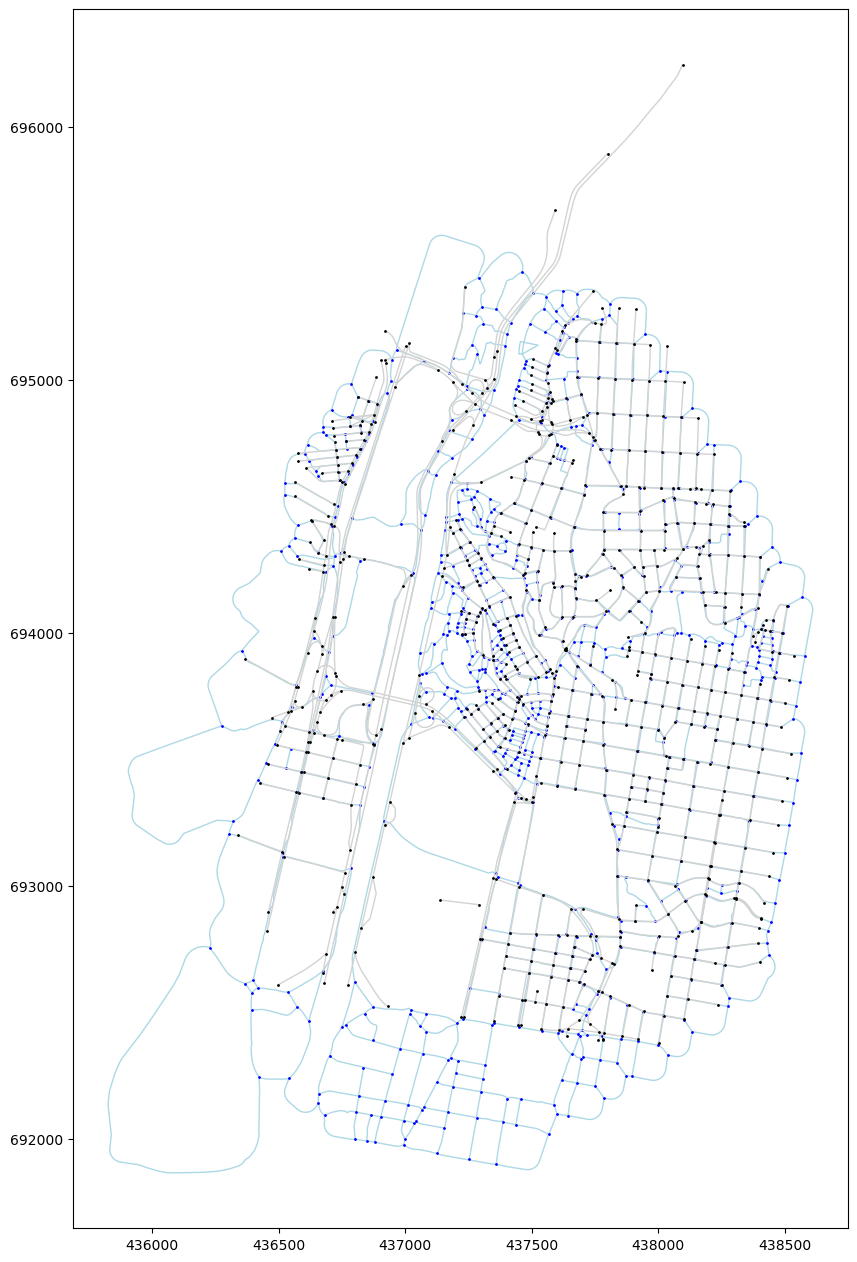

In [11]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "00_networks_visualization.svg")

## Step 1: Identify the parts of the Tessellations network that should be added to the Boeing network

###  __Step 1 - Plan A__ Explanation
#### Create a buffer around all Tess nodes. If the buffer touches the Boeing network, consider that part of the Tess network as already covered by the Boeing network. For the rest of the nodes, find the edges that connect to them and find the node that would be used to connect to the Boeing network (Nodes that are connected to the selected Tess network and whose buffer touches the Boeing network)

#### __Result:__ Worked well when joining OSMnx + Boeing network, but some lines were not considered. (e.g. a street whose nodes are located very close to the Boeing Network, but whose path [edge] crosses an uncovered zone). When trying to join Tessellations+Boeing several problems arised. --> __Plan B__ works by considering the representative_point() of complementary (Tessellation) edges as the point of interest to check if it is close enough to the base (Boeing) network [Instead of using the complementary (Tesellations) nodes].

### __Step 1 - Plan A__ Development

#### __1-A.1__ Create buffer around each node (Keeping osmid)

In [12]:
# Reset node's index
tess_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

# Save each node's reseted index in a column named 'index'
nodes_to_buffer = tess_nodes.copy()
nodes_to_buffer.reset_index(inplace=True) #--> Creates col 'index'

# Create a gdf containing the buffer around nodes
tess_nodes_buffer = nodes_to_buffer.buffer(10)
tess_nodes_buffer = gpd.GeoDataFrame(geometry=tess_nodes_buffer)
tess_nodes_buffer.reset_index(inplace=True) #--> Creates col 'index'

# Transfer data from nodes to its buffer using the index as merge col
nodes_to_buffer.drop(columns=['geometry'],inplace=True)
tess_nodes_buffer = pd.merge(tess_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using col 'index'
tess_nodes_buffer.drop(columns=['index'],inplace=True)

# Show
print(tess_nodes_buffer.shape)
tess_nodes_buffer.head(2)

(978, 2)


,geometry,osmid
0,"POLYGON ((437397.239 692067.632, 437397.191 69...",0
1,"POLYGON ((437446.817 692056.015, 437446.768 69...",1


<Axes: >

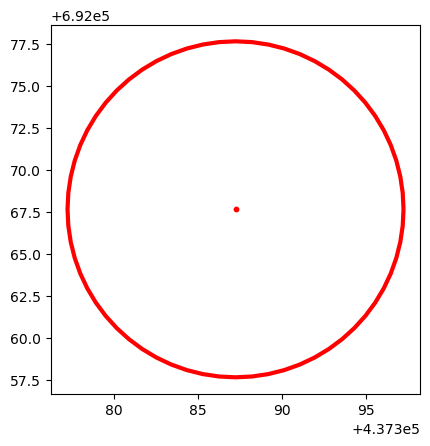

In [13]:
osmid_test = 0

node_test = tess_nodes.loc[tess_nodes.osmid==osmid_test]
buffer_test = tess_nodes_buffer.loc[tess_nodes_buffer.osmid==osmid_test]

# Plot
fig,ax = plt.subplots(1,1)

node_test.plot(ax=ax,zorder=1,color='red',markersize=10)
buffer_test.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

#### __1-A.2__ Find nodes whose buffer does not intersect with any part of the Boeing network

In [14]:
# Buffers that touch any Boeing edge
buffer_touch = tess_nodes_buffer.sjoin(boeing_edges)
osmid_touch_lst = list(buffer_touch.osmid.unique())

# Nodes that are not near any Boeing edge
tess_uncovered_nodes = tess_nodes.loc[~tess_nodes.osmid.isin(osmid_touch_lst)]

# Show
print(tess_uncovered_nodes.shape)
tess_uncovered_nodes.head(2)

(306, 2)


,osmid,geometry
0,0,POINT (437387.239 692067.632)
1,1,POINT (437436.817 692056.015)


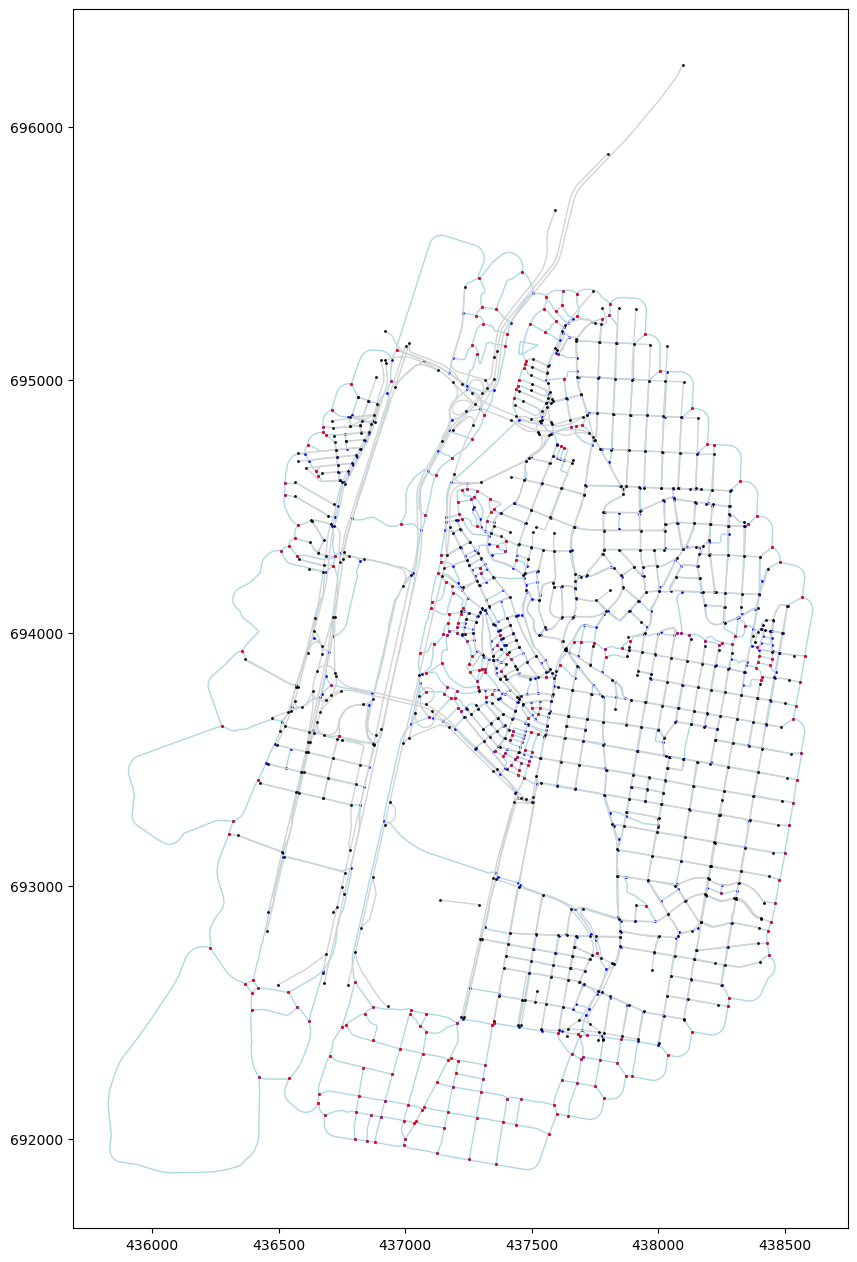

In [15]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

tess_uncovered_nodes.plot(ax=ax,zorder=4,color='red',markersize=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PlanA_01_uncovered_nodes.svg")

#### __1-A.3__ Select the edges that connect to the uncovered nodes

In [16]:
# List of unique osmids that are currently uncovered
tess_uncovered_osmid_lst = list(tess_uncovered_nodes.osmid.unique())
# Select any edge where its 'u' or 'v' is in tess_uncovered_osmid_lst
tess_uncovered_edges = tess_edges.loc[(tess_edges.u.isin(tess_uncovered_osmid_lst)) | (tess_edges.v.isin(tess_uncovered_osmid_lst))].copy()

# Show
print(tess_uncovered_edges.shape)
tess_uncovered_edges.head(2)

(628, 4)


,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."


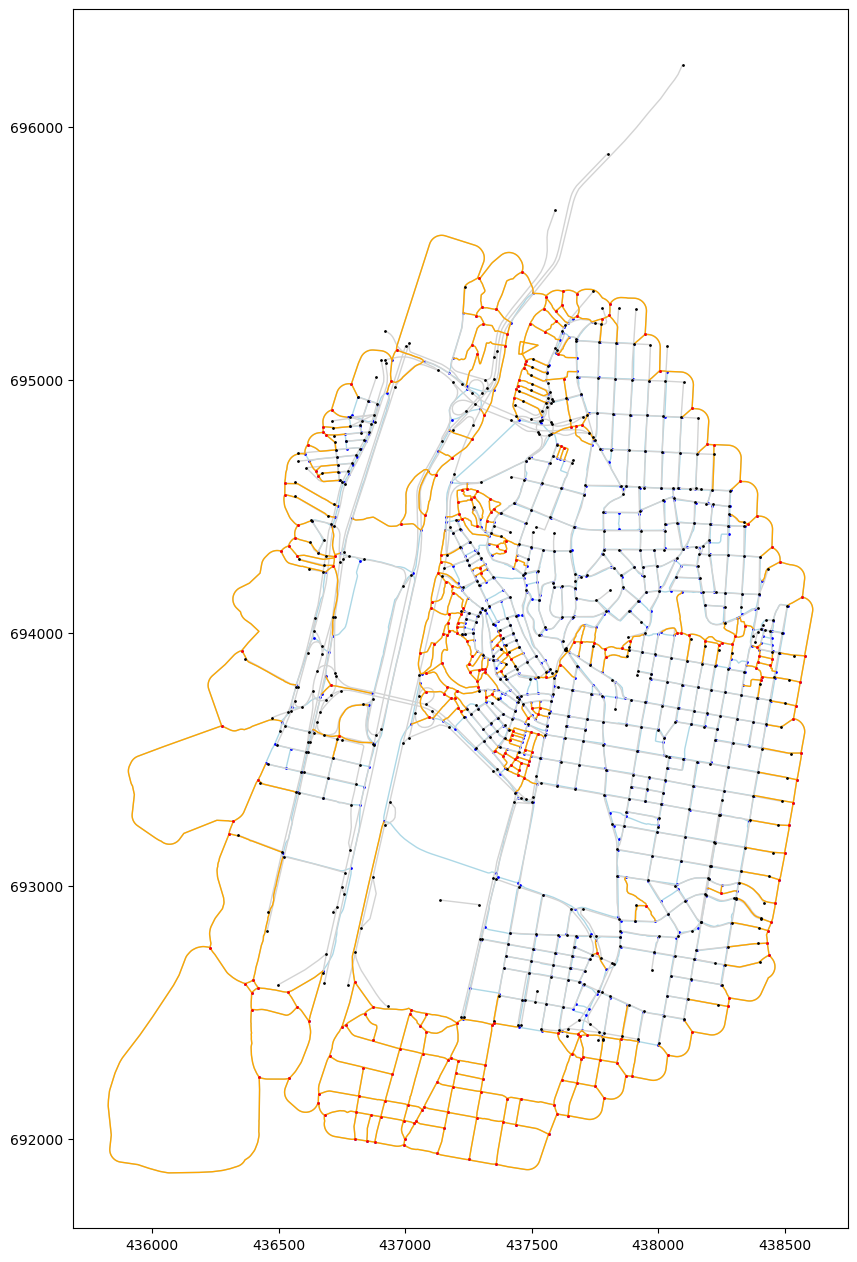

In [21]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

tess_uncovered_nodes.plot(ax=ax,zorder=5,color='red',markersize=1)
tess_uncovered_edges.plot(ax=ax,zorder=3,color='orange',linewidth=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PlanA_02_uncovered_edges.svg")

#### __1-A.4__ Find the nodes that would be used to connect the uncovered network to the Boeing network

In [18]:
# Find all non-duplicated (set) unique 'u's and 'v's in the tess_uncovered_edges gdf.
uncovered_vertexes = set(list(tess_uncovered_edges.u.unique()) + list(tess_uncovered_edges.v.unique()))
# From those vertexes, find those that do not form part of the uncovered network
contact_osmids = [osmid for osmid in uncovered_vertexes if osmid not in tess_uncovered_osmid_lst]
# Select nodes from those osmids
contact_nodes = tess_nodes.loc[tess_nodes.osmid.isin(contact_osmids)].copy()

# Show
print(contact_nodes.shape)
contact_nodes.head(2)

(243, 2)


,osmid,geometry
8,4,POINT (437921.235 692384.410)
9,5,POINT (438000.016 692369.895)


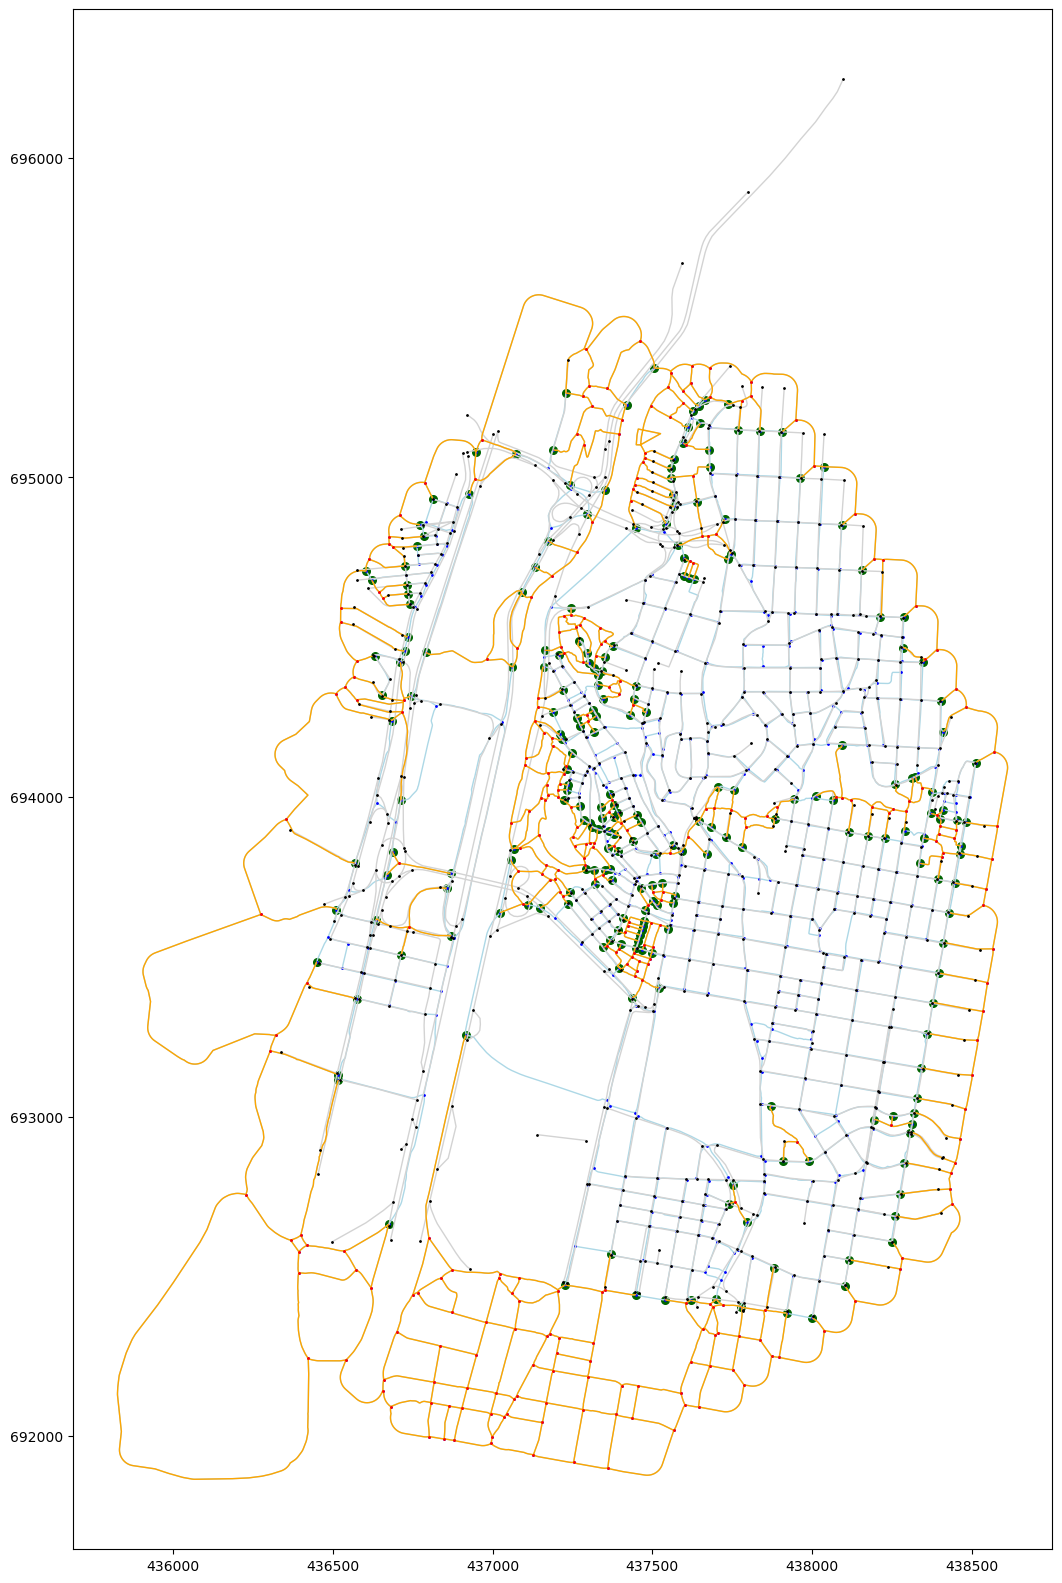

In [22]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(20,20))

tess_uncovered_nodes.plot(ax=ax,zorder=5,color='red',markersize=1)
tess_uncovered_edges.plot(ax=ax,zorder=3,color='orange',linewidth=1)
boeing_nodes.plot(ax=ax,zorder=3,color='black',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='lightgrey',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='blue',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='lightblue',linewidth=1)

contact_nodes.plot(ax=ax,zorder=-1,color='darkgreen',markersize=30)

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + "PlanA_03_contact_nodes.svg")

### __Step 1 - Plan A__ Function

In [24]:
def identify_uncovered(base_edges, complementary_nodes, complementary_edges, uncovered_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) 
        where currently there's no coverture in a base network.
	Args:
		base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		uncovered_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {uncovered_dist} is created around all complementary_nodes. If the buffer touches the base_edges, the node
                                from that buffer is considered as already covered by the base network. If the buffer does not touches the base_edges,
                                the complementary node is considered a complementary_uncovered_node.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that 
                                                                are not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that 
                                                                are not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""
    # 1.0 --------------- Create buffer around complementary_nodes (keeping nodes ID)
    # ------------------- INPUT - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- 
    
    # Reset complementary node's index
    complementary_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary node's reseted index in a column named 'index'
    nodes_to_buffer = complementary_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Create a gdf containing the buffer around complementary nodes
    complementary_nodes_buffer = nodes_to_buffer.buffer(uncovered_dist)
    complementary_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_nodes_buffer)
    complementary_nodes_buffer.reset_index(inplace=True) #--> Creates col 'index'
    # Transfer data from complementary nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_nodes_buffer = pd.merge(complementary_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using col 'index'
    complementary_nodes_buffer.drop(columns=['index'],inplace=True)
    
    # 2.0 --------------- Find complementary nodes whose buffer does not intersect with any part of the base network
    # ------------------- INPUT - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = complementary_nodes_buffer.sjoin(base_edges)
    osmid_touch_lst = list(buffer_touch.osmid.unique())
    # Nodes that are not near any base edge
    complementary_uncovered_nodes = complementary_nodes.loc[~complementary_nodes.osmid.isin(osmid_touch_lst)].copy()

    # 3.0 --------------- Select the complementary edges that connect to the complementary uncovered nodes
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    
    # List of unique osmids that are currently uncovered
    complementary_uncovered_osmid_lst = list(complementary_uncovered_nodes.osmid.unique())
    # Select any edge where its 'u' or 'v' is in complementary_uncovered_osmid_lst
    complementary_uncovered_edges = complementary_edges.loc[(complementary_edges.u.isin(complementary_uncovered_osmid_lst)) | (complementary_edges.v.isin(complementary_uncovered_osmid_lst))].copy()

    # 4.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network
    
    # Find all non-duplicated (set) unique 'u's and 'v's in the complementary_uncovered_edges gdf
    uncovered_vertexes = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # From those vertexes, find those that do not form part of the uncovered network
    # (Meaning, discard the complementary_uncovered_osmid_lst. Those osmids are far from the base network. We need to know which ones are close, those will be our connecting points.)
    contact_osmids = [osmid for osmid in uncovered_vertexes if osmid not in complementary_uncovered_osmid_lst]
    # Select nodes from those osmids
    contact_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(contact_osmids)].copy()

    
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes

Join network using a uncovered distance of 5.
Join network using a uncovered distance of 10.
Join network using a uncovered distance of 15.


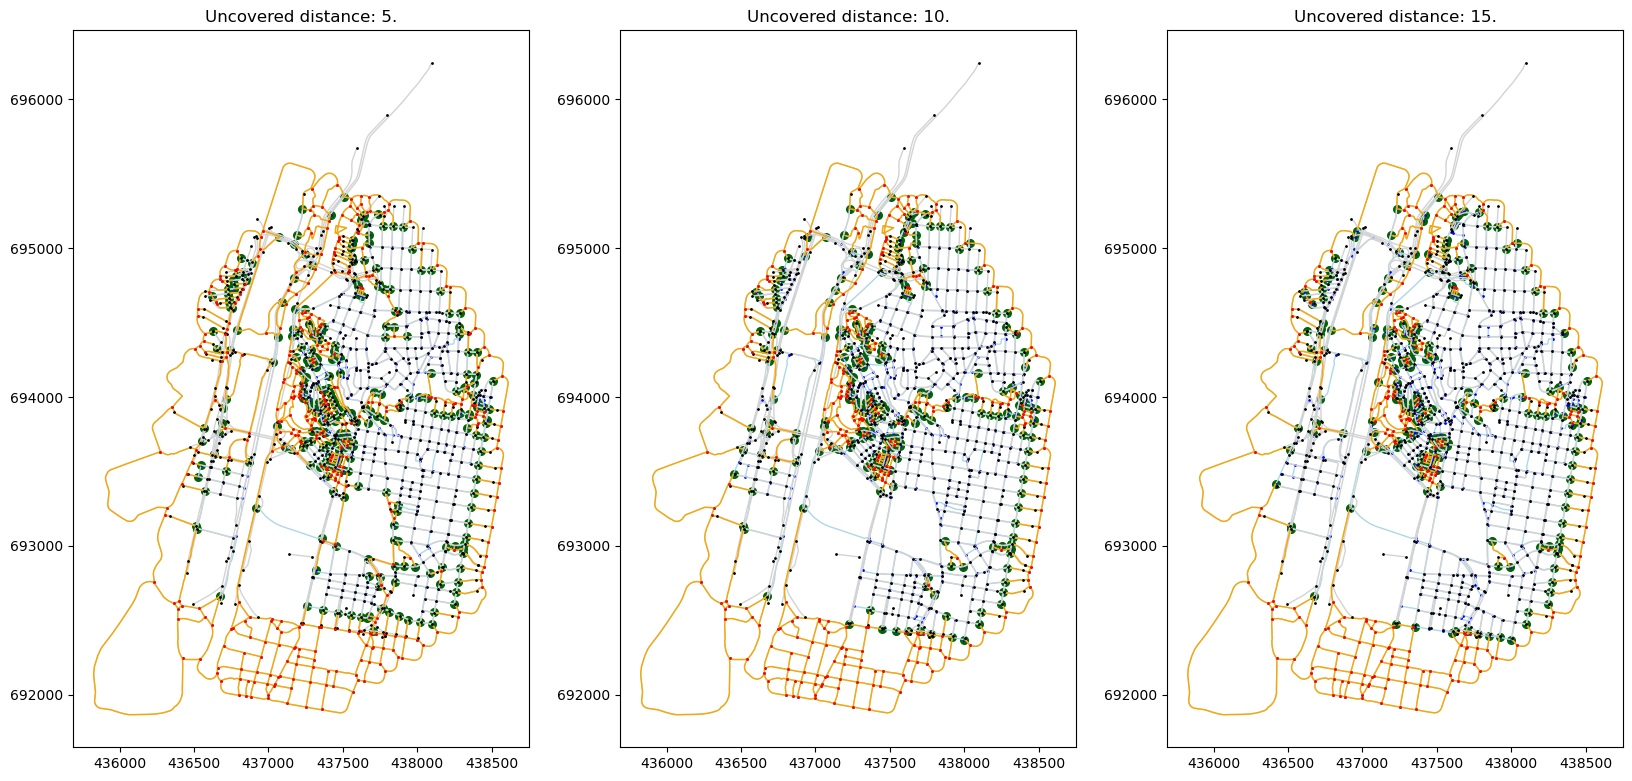

In [25]:
distances_test = [5,10,15]

fig,axs = plt.subplots(1,len(distances_test),figsize=(20,20))
i = 0

for distance in distances_test:
    # Identify join network
    print(f"Join network using a uncovered distance of {distance}.")
    complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes = identify_uncovered(base_edges = boeing_edges,
                                                                                                     complementary_nodes = tess_nodes,
                                                                                                     complementary_edges = tess_edges, 
                                                                                                     uncovered_dist = distance,
                                                                                                     projected_crs = projected_crs)

    # Plot
    complementary_uncovered_nodes.plot(ax=axs[i],zorder=5,color='red',markersize=1)
    complementary_uncovered_edges.plot(ax=axs[i],zorder=3,color='orange',linewidth=1)
    boeing_nodes.plot(ax=axs[i],zorder=3,color='black',markersize=1)
    boeing_edges.plot(ax=axs[i],zorder=2,color='lightgrey',linewidth=1)
    tess_nodes.plot(ax=axs[i],zorder=1,color='blue',markersize=1)
    tess_edges.plot(ax=axs[i],zorder=0,color='lightblue',linewidth=1)
    
    contact_nodes.plot(ax=axs[i],zorder=-1,color='darkgreen',markersize=30)

    # Format - Title
    axs[i].set_title(f"Uncovered distance: {distance}.")

    i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + f"PartA_distances_{distances_test}.svg")

###  __Step 1 - Plan B__ Explanation

#### __Plan B__ works by considering the representative_point() of complementary (Tessellation) edges as the point of interest to check if it is close enough to the base (Boeing) network [Instead of using the complementary (Tesellations) nodes].

#### __Representative_point() test__

In [26]:
edges_test = tess_edges.loc[(tess_edges.u==0)].copy()
edges_test

,u,v,key,geometry
0,0,1,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
1,0,3,0,"LINESTRING (437387.239 692067.632, 437387.456 ..."
2,0,230,0,"LINESTRING (437387.239 692067.632, 437387.021 ..."
3,0,191,0,"LINESTRING (437387.239 692067.632, 437387.021 ..."


In [27]:
edges_test['representative_point'] = edges_test.representative_point()
representative_points_test = edges_test[['u','v','key','representative_point']].copy()
representative_points_test.rename(columns={'representative_point':'geometry'},inplace=True)
 
representative_points_test

,u,v,key,geometry
0,0,1,0,POINT (437411.553 692060.506)
1,0,3,0,POINT (437373.040 691984.151)
2,0,230,0,POINT (437396.146 692112.701)
3,0,191,0,POINT (437335.372 692075.471)


<Axes: >

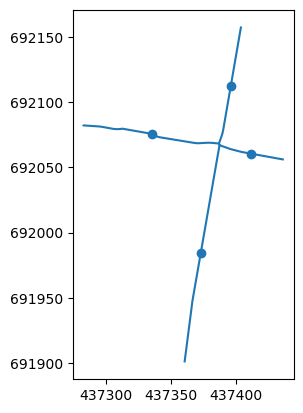

In [28]:
fig,ax=plt.subplots()
edges_test.plot(ax=ax)
representative_points_test.plot(ax=ax)

### __Step 1 - Plan B__ Function

In [33]:
def identify_uncovered(base_edges, complementary_nodes, complementary_edges, contact_analysis_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		contact_analysis_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {uncovered_dist} is created around all complementary_nodes. If the buffer touches the base_edges, the node
                                from that buffer is considered as already covered by the base network. If the buffer does not touches the base_edges,
                                the complementary node is considered a complementary_uncovered_node.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that 
                                                                are not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that 
                                                                are not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # 1.0 --------------- Extract representative point of each complementary edge
    # ------------------- INPUT - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v
    complementary_edges['u'] = complementary_edges['u'].astype('str')
    complementary_edges['v'] = complementary_edges['v'].astype('str')
    complementary_edges['edge_id'] = complementary_edges['u']+complementary_edges['v']
    # Return 'u' and 'v' to int
    complementary_edges['u'] = complementary_edges['u'].astype('int')
    complementary_edges['v'] = complementary_edges['v'].astype('int')
    # Find representative point of each edge
    complementary_edges['representative_point'] = complementary_edges.representative_point()
    # Assign representative point to its own gdf and drop representative_point from complementary_edges
    representative_points = complementary_edges[['edge_id','representative_point']].copy()
    representative_points.rename(columns={'representative_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['representative_point'],inplace=True)
    
    # 2.0 --------------- Create contact-analysis buffer around representative points (keeping u and v data)

    # Reset representative_points's index
    representative_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each representative_points's reseted index in a column named 'index'
    points_to_buffer = representative_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Creates reseted col 'index'
    # Create a gdf containing the contact-analysis buffer around representative_points
    representative_points_buffer = points_to_buffer.buffer(contact_analysis_dist)
    representative_points_buffer = gpd.GeoDataFrame(geometry=representative_points_buffer)
    representative_points_buffer.reset_index(inplace=True) #--> Creates reseted col 'index'
    # Transfer data from representative_points to it's buffer using the previously reseted index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    representative_points_buffer = pd.merge(representative_points_buffer,points_to_buffer,on='index') #--> Merges using reseted col 'index'
    representative_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find representative_points whose buffer does not intersect with any part of the base network
    # ------------------- INPUT - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = representative_points_buffer.sjoin(base_edges)
    # All unique complementary edge_ids that touched any base_edge
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Complementary edges that ARE NOT(~) near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()

    # 3.0 --------------- Select the complementary nodes that connect to the complementary_uncovered_edges
    # ------------------- INPUT - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- INPUT - READ COMPLEMENTARY NODES 
    
    # List of unique 'u's and 'v's that are currently uncovered
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any node where its 'osmid' IS in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()

    # 4.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network

    # 4.1 --- Create a buffer around all complementary_uncovered_nodes (All nodes that have a relation to all complementary_uncovered_edges)
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Creates reseted col 'index'
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(contact_analysis_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Creates reseted col 'index'
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using reseted col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 4.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    # All unique osmids that touched any base_edge
    contact_osmids = list(buffer_touch.osmid.unique())
    # Complementary nodes that ARE near any base_edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()

    # 5.0 --------------- Create missing connections
    
    # Review each node in the uncovered zone of the complementary network
    for osmid in complementary_uncovered_osmid_lst:

        # If the node is already a contact node, skip
        if osmid in contact_osmids:
            continue

        # If it is not, check it's edges (diverging_edges)
        diverging_edges = complementary_edges.loc[(complementary_edges.u.isin(complementary_uncovered_osmid_lst)) | (complementary_edges.v.isin(complementary_uncovered_osmid_lst))].copy()
        diverging_edges_ids = list(diverging_edges.edge_id.unique())

        # For each edge diverging from current node, if the edge DOES touch the base network:
        for edge_id in diverging_edges_ids:
            if edge_id in edge_id_touch_lst: # (edge_id_touch_lst was previously used to identify the contrary, edges that DO NOT touch the base network)
                # If an edge reaches this code it means that it is an edge that: 
                # 1. Diverges from the uncovered part of the complementary network into the base network
                # 2. One of its nodes is an uncovered node that IS NOT a contact node
                # 3. It's representative_point() touches the base network
                # --> It is missing a connection within the edge itself. Create that connection between the complementary and base network.
                
                # Select the edge
                connection_edge = complementary_edges.loc[complementary_edges.edge_id == edge_id].copy()
                # Recalculate its representative_point()
                connection_edge['representative_point'] = connection_edge.representative_point()
                # Assign representative point to its own gdf
                representative_point = connection_edge[['edge_id','representative_point']].copy()
                representative_point.rename(columns={'representative_point':'geometry'},inplace=True)
                connection_edge.drop(columns=['representative_point'],inplace=True)
                
                
                
                

    
    
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, representative_points_buffer, complementary_uncovered_nodes_buffer

Join network using a uncovered distance of 5.
Join network using a uncovered distance of 10.
Join network using a uncovered distance of 15.


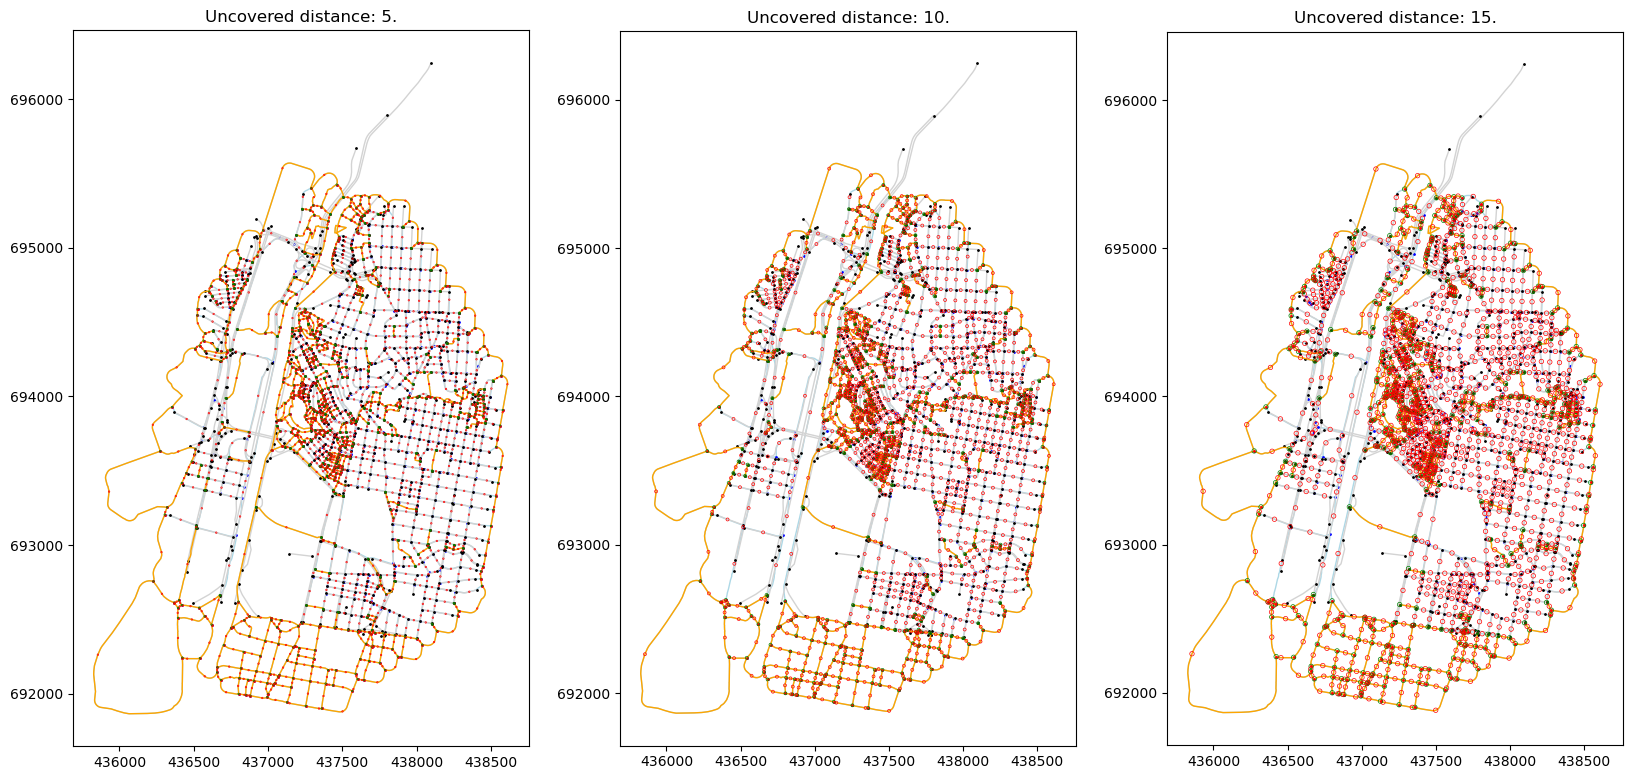

In [36]:
distances_test = [5,10,15]

fig,axs = plt.subplots(1,len(distances_test),figsize=(20,20))
i = 0

for distance in distances_test:
    # Identify join network
    print(f"Join network using a uncovered distance of {distance}.")
    complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, representative_points_buffer, complementary_uncovered_nodes_buffer = identify_uncovered(
        base_edges = boeing_edges,
        complementary_nodes = tess_nodes,
        complementary_edges = tess_edges, 
        contact_analysis_dist = distance,
        projected_crs = projected_crs)

    # Plot
    complementary_uncovered_nodes_buffer.plot(ax=axs[i],zorder=7,facecolor='None',edgecolor='green',linewidth=0.5)
    representative_points_buffer.plot(ax=axs[i],zorder=7,facecolor='None',edgecolor='red',linewidth=0.5)
    
    contact_nodes.plot(ax=axs[i],zorder=6,color='darkgreen',markersize=1)
    complementary_uncovered_nodes.plot(ax=axs[i],zorder=5,color='red',markersize=1)
    complementary_uncovered_edges.plot(ax=axs[i],zorder=4,color='orange',linewidth=1)
    boeing_nodes.plot(ax=axs[i],zorder=3,color='black',markersize=1)
    boeing_edges.plot(ax=axs[i],zorder=2,color='lightgrey',linewidth=1)
    tess_nodes.plot(ax=axs[i],zorder=1,color='blue',markersize=1)
    tess_edges.plot(ax=axs[i],zorder=0,color='lightblue',linewidth=1)
    
    

    # Format - Title
    axs[i].set_title(f"Uncovered distance: {distance}.")

    i+=1

# ---------- Save Plot ----------
if save_plots:
    plt.savefig(savefig_dir + f"PlanB_distances_{distances_test}.svg")

## __Solving:__ Cases where there's no contact_node() being assigned due to it's location

#### __Explanation:__ Whenever a complementary_uncovered_edge (orange line) connects to a complementary_uncovered_node (red dot) which is not close to the base network (Gray linestrings/black points), theres a connection missing.

#### The connection would be located in the subsequent edge, which would travel from that complementary_uncovered_node to the next complementary_node. But that edge and that next complementary_node is located within proximity to the base network.

#### In order to avoid duplicating edges/streets by including the whole subsequent edge and node, the function representative_shortening() was created.

### __representative_shortening():__ Function development

In [403]:
# Distance between two points
def distance(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

__Test node__ (Simulates being the last complementary_uncovered_node)

In [418]:
osmid = 262
# Extract node
node_analysis = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid == osmid].copy()
# Reset index (so it's always .loc[0,'geometry'])
node_analysis.reset_index(inplace=True, drop=True)

node_analysis

,osmid,geometry
0,262,POINT (436800.995 692619.777)


__Test edge__ (Simulates being the subsequent complementary_edge)

In [428]:
edge_id = '260262'

##### ##### ##### ##### ##### Simulate complementary_edges
complementary_edges = tess_edges.copy()
# Create unique ID for each edge using u+v
complementary_edges['u'] = complementary_edges['u'].astype('str')
complementary_edges['v'] = complementary_edges['v'].astype('str')
complementary_edges['edge_id'] = complementary_edges['u']+complementary_edges['v']
# Return 'u' and 'v' to int
complementary_edges['u'] = complementary_edges['u'].astype('int')
complementary_edges['v'] = complementary_edges['v'].astype('int')
##### ##### ##### ##### ##### Simulate complementary_edges

# Select the edge
connection_edge = complementary_edges.loc[complementary_edges.edge_id == edge_id].copy()
connection_edge.reset_index(inplace=True,drop=True)

connection_edge

,u,v,key,geometry,edge_id
0,260,262,0,"LINESTRING (436917.704 693254.374, 436917.701 ...",260262


<Axes: >

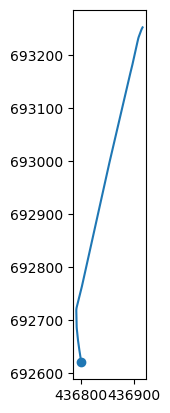

In [424]:
fig,ax = plt.subplots()

node_analysis.plot(ax=ax)
connection_edge.plot(ax=ax)

In [425]:
def representative_shortening(connection_edge,node_analysis):
    
    """ This function calculates the representative_point() of a line and shortens the line from the starting_point to the representative_point(). 
	Args:
		connection_edge (geopandas.GeoDataFrame): GeoDataFrame containing the edge to be shortened. Requires column 'geometry' with a LineString.
        node_analysis (geopandas.GeoDataFrame): GeoDataFrame containing the starting_point of the LineString, dictates which part to keep. 
                                                Requires column 'geometry' with a Point.
	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with fsdffdssfd
	"""
    
    # 1.0 --------------- Calculate the edge's representative_point()
    # Calculate the connection_edge's representative_point
    connection_edge['representative_point'] = connection_edge.representative_point()
    # Assign representative point to its own gdf
    representative_point = connection_edge[['edge_id','representative_point']].copy()
    representative_point.rename(columns={'representative_point':'geometry'},inplace=True)
    connection_edge.drop(columns=['representative_point'],inplace=True)
    
    # 2.0 --------------- Split the connection_edge using it's representative_point()
    # Extract the connection_edge's geometry (LineString)
    connection_edge_geom = connection_edge['geometry'].unique()[0]
    # Extract the representative_point's geometry (Point)
    representative_point_geom = representative_point['geometry'][0]
    # Project the representative_point onto the line (In case it didn't fall right in the LineString)
    projected_point = connection_edge_geom.interpolate(connection_edge_geom.project(representative_point_geom))
    # Split the connection_edge where the projected representative_point is
    split_lines = split(connection_edge_geom, projected_point)
    # Convert the split lines to a GeoDataFrame
    split_gdf = gpd.GeoDataFrame(geometry=list(split_lines.geoms), crs=projected_crs)

    # 3.0 --------------- Select the split part of the LineString where the starting point is the node being analysed

    # Extract connection_edge's coordinates
    edge_coords = list(connection_edge['geometry'][0].coords)

    # Extract the node_analysis's coordinates
    node_analysis_coords = node_analysis.loc[0,'geometry'].coords[0]
    
    # Distance from node being analysed to first point
    first_point = edge_coords[0]
    first_point_distance = distance(first_point, node_analysis_coords)
    
    # Distance from node being analysed to last point
    last_point = edge_coords[-1]
    last_point_distance = distance(last_point, node_analysis_coords)
    
    # Decide which one is the starting_point to keep
    if first_point_distance < last_point_distance:
        # Starting point is first_point
        starting_point = first_point
    else:
        # Starting point is last_point
        starting_point = last_point
        
    # Find the line from split_gdf where that starting_point is located
    if starting_point in list(split_gdf.loc[0,'geometry'].coords):
        # Extract first line geometry
        split_connection_edge_geom = split_gdf.loc[0,'geometry']
    elif starting_point in list(split_gdf.loc[1,'geometry'].coords):
        # Extract second line geometry
        split_connection_edge_geom = split_gdf.loc[1,'geometry']
    
    # Convert to a GeoDataFrame
    split_connection_edge = gpd.GeoDataFrame()
    split_connection_edge.loc[0,'geometry'] = split_connection_edge_geom
    split_connection_edge = split_connection_edge.set_crs(projected_crs)

    return representative_point, split_connection_edge

In [426]:
representative_point, split_connection_edge = representative_shortening(connection_edge,node_analysis)
split_connection_edge

,geometry
0,"LINESTRING (436841.165 692939.101, 436841.145 ..."


<Axes: >

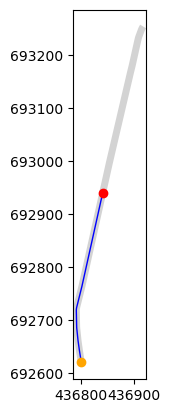

In [429]:
fig,ax = plt.subplots()

node_analysis.plot(ax=ax,zorder=2,color='orange')
representative_point.plot(ax=ax,zorder=2,color='red')
split_connection_edge.plot(ax=ax,zorder=1,color='blue',linewidth=1)
connection_edge.plot(ax=ax,zorder=0,color='lightgrey',linewidth=5)

### __representative_shortening():__ Aplication testing

## Original __(Canceled)__ development

In [212]:
def get_multiline_angle(row):
    
    geom = row['geometry']
    
    if isinstance(geom, MultiLineString):
        # Get geometry
        multi_line = row.geometry
        
        # Get the first LineString in the MultiLineString
        first_line = multi_line.geoms[0]
        # Get the last LineString in the MultiLineString
        last_line = multi_line.geoms[-1]
        
        # Get the starting point (first coordinate of the first LineString)
        start_point = first_line.coords[0]
        # Get the ending point (last coordinate of the last LineString)
        end_point = last_line.coords[-1]

    elif isinstance(geom, LineString):
        
        # Get geometry
        line = row.geometry
        # Get the starting point
        start_point = line.coords[0]
        # Get the ending point
        end_point = line.coords[-1]
    
    # Calculate the differences in coordinates
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    # Calculate the angle in radians
    angle_radians = math.atan2(dy, dx)
    # Convert the angle to degrees
    angle_degrees = math.degrees(angle_radians)
    # If angle is negative, make positive
    if angle_degrees < 0:
        angle_degrees += 360
        
    # Change angle to 0° to 180° format
    if angle_degrees > 180:
        angle_reversed = angle_degrees - 180
        row['line_angle'] = angle_reversed
    else:
        row['line_angle'] = angle_degrees

    return row

In [ ]:
edge_coords_df = gpd.GeoDataFrame()

# Extract representative_point's coords
representative_coords = representative_point['geometry'][0].coords[0]

# Order connection_edge's coordinates and calculate distance from each connection_edge coordinate to the representative_point coordinates
i = 0
for coords in edge_coords:
    edge_coords_df.loc[i,'coord_loc'] = i
    edge_coords_df.loc[i,'geometry'] = Point(coords)
    edge_coords_df.loc[i,'distance'] = distance(representative_coords, coords)
    i+=1

edge_coords_df

In [349]:
# Finding starting point
if first_point_distance < last_point_distance:
    starting = 'first'
else:
    starting = 'last'   

# Find the closest edge coordinate to the representative_point()
min_distance = min(edge_coords_df['distance'])
closest_row = edge_coords_df.loc[edge_coords_df['distance'] == min_distance]
closest_iloc = min_distance_row['coord_loc'].unique()[0] # --> iloc, position on the edge

# If the representative point landed EXACTLY over one of the edges vertexes, the distance will be cero.
# In this case it is not necessary to modify the line, just to cut it up until that vertex.
if min_distance == 0:
    
    # If the starting point is in the vertex 0, select from 0 to closest_iloc.
    if starting == 'first':
        edge_coords_gdf = edge_coords_df.iloc[0 : int(closest_iloc)+1].copy()
        # Format
        edge_coords_gdf = edge_coords_gdf [["coord_loc","geometry"]]
        
    # If the starting point is in the last vertex, select from closest_iloc to end of gdf.
    elif starting == 'last':
        edge_coords_gdf = edge_coords_df.iloc[int(closest_iloc)+1 : len(edge_coords_df)-1].copy()
        # Format
        edge_coords_gdf = edge_coords_gdf [["coord_loc","geometry"]]

# If the representative point ["rp()"] is not EXACTLY over one of the edge vertexes, 
# it is necessary to find it's location (iloc) with respect to the closest vertexes. This is done by:
# 1. Selecting the closest edge coordinate ["closest"] and creating a vectorial line from the "rp()" to that coordinate [LineString rp()-->closest]
# 2. Repeating that process for the previous edge coordinate ["iloc-1"] and subsequent edge coordinate ["iloc+1"].
# 3. Finding the angle for each vectorial line. 

# If the angle of [LineString rp()-->closest] and the angle of [Linestring rp()-->iloc-1] are more similar than the angle of [Linestring rp()-->iloc+1],
# it means that edge coord "iloc-1" is in the direction of closest and edge coord iloc+1 is in the oposite direction.
# Therefore, the rp() would be located between edge coord "closest" and edge coord "iloc+1". 
# And the other way around.

else:
    vectorial_linestrings = gpd.GeoDataFrame()
    
    # Get "closest" edge_coord coordinates
    closest_geom = closest_row.geometry.unique()[0]
    closest_geom_x = closest_geom.coords[0][0]
    closest_geom_y = closest_geom.coords[0][1]
    # Draw a line from the rp() to the "closest" edge_coord coordinates
    vectorial_linestrings.loc[0,'relation'] = 'representative_closest'
    vectorial_linestrings.loc[0,'geometry'] = LineString([[representative_coords[0],representative_coords[1]],[closest_geom_x,closest_geom_y]])
    
    # Get "iloc-1" edge_coord coordinates
    minus_one_row = edge_coords_df.iloc[int(closest_iloc)-1].copy()
    minus_one_geom = minus_one_row.geometry
    minus_one_geom_x = minus_one_geom.coords[0][0]
    minus_one_geom_y = minus_one_geom.coords[0][1]
    # Draw a line from the rp() to the "iloc-1" edge_coord coordinates
    vectorial_linestrings.loc[1,'relation'] = 'representative_minus_one'
    vectorial_linestrings.loc[1,'geometry'] = LineString([[representative_coords[0],representative_coords[1]],[minus_one_geom_x,minus_one_geom_y]])
    
    # Get "iloc+1" edge_coord coordinates
    plus_one_row = edge_coords_df.iloc[int(min_distance_loc)+1]
    # Draw a line from the rp() to the "iloc+1" edge_coord coordinates
    plus_one_geom = plus_one_row.geometry
    plus_one_geom_x = plus_one_geom.coords[0][0]
    plus_one_geom_y = plus_one_geom.coords[0][1]
    vectorial_linestrings.loc[2,'relation'] = 'representative_plus_one'
    vectorial_linestrings.loc[2,'geometry'] = LineString([[representative_coords[0],representative_coords[1]],[plus_one_geom_x,plus_one_geom_y]])

    # Get vectorial LineStrings direction angles
    vectorial_linestrings = vectorial_linestrings.apply(get_multiline_angle,axis=1)


# Find which ("iloc-1" or "iloc+1") is in the oposite direction to [LineString rp()-->closest]
rp_closest_lineangle = vectorial_linestrings.loc[vectorial_linestrings.relation=='representative_closest'].line_angle.unique()[0]
rp_minus_lineangle = vectorial_linestrings.loc[vectorial_linestrings.relation=='representative_minus_one'].line_angle.unique()[0]
rp_plus_lineangle = vectorial_linestrings.loc[vectorial_linestrings.relation=='representative_plus_one'].line_angle.unique()[0]


if (rp_closest_lineangle - rp_minus_lineangle) < (rp_closest_lineangle - rp_plus_lineangle):
    # It means rp()-->"iloc-1" is in the direction of rp()-->"closest".
    # rp()-->"iloc+1" is in the opposite direction
    # rp() is located between "closest" and "iloc+1"

    if starting == 'first':
        # If the starting point is in the vertex 0, select from 0 to closest_iloc.
        edge_coords_gdf = edge_coords_df.iloc[0 : int(closest_iloc)+1].copy()
        # Add rp() coord at the end
        edge_coords_gdf.loc[int(closest_iloc)+2,"coord_loc"] = int(closest_iloc)+1
        edge_coords_gdf.loc[int(closest_iloc)+2,"geometry"] = Point(representative_coords)
        # Format
        edge_coords_gdf = edge_coords_gdf [["coord_loc","geometry"]]
    
    elif starting == 'last':
        # Elif the starting point is in the last vertex, select from closest_iloc to end of gdf.
        coords_gdf = edge_coords_df.iloc[int(closest_iloc)+1 : len(edge_coords_df)-1].copy()
        # Add one position to each coord
        coords_gdf['coord_loc'] = edge_coords_gdf['coord_loc']+1
        # Add rp() coord at the start
        edge_coords_gdf = gpd.GeoDataFrame()
        edge_coords_gdf.loc[0,'coord_loc'] = 0
        edge_coords_gdf.loc[0,'geometry'] = Point(representative_coords)
        edge_coords_gdf = pd.concat([edge_coords_gdf,coords_gdf[['coord_loc','geometry']])
        edge_coords_gdf.reset_index(inplace=True,drop=True)

else:
    # It means rp()-->"iloc+1" is in the direction of rp()-->"closest".
    # rp()-->"iloc-1" is in the opposite direction
    # rp() is located between "iloc-1" and "closest" 
    
    if starting == 'first':
        # If the starting point is in the vertex 0, select from 0 to "iloc-1".
        edge_coords_gdf = edge_coords_df.iloc[0 : int(closest_iloc)].copy()
        # Add rp() coord at the end (Substitutes closest)
        edge_coords_gdf.loc[int(closest_iloc)+1,"coord_loc"] = int(closest_iloc)
        edge_coords_gdf.loc[int(closest_iloc)+1,"geometry"] = Point(representative_coords)
        # Format
        edge_coords_gdf = edge_coords_gdf [["coord_loc","geometry"]]
    
    elif starting == 'last':
        # Elif the starting point is in the last vertex, select from "iloc-1" to end of gdf.
        coords_gdf = edge_coords_df.iloc[int(closest_iloc) : len(edge_coords_df)-1].copy()
        # Add one position to each coord
        coords_gdf['coord_loc'] = edge_coords_gdf['coord_loc']+1
        # Add rp() coord at the start
        edge_coords_gdf = gpd.GeoDataFrame()
        edge_coords_gdf.loc[0,'coord_loc'] = 0
        edge_coords_gdf.loc[0,'geometry'] = Point(representative_coords)
        edge_coords_gdf = pd.concat([edge_coords_gdf,coords_gdf[['coord_loc','geometry']])
        edge_coords_gdf.reset_index(inplace=True,drop=True)
    
                            
edge_coords_gdf

,coord_loc,geometry,distance
0,0.0,POINT (437387.239 692067.632),84.68
1,1.0,POINT (437387.456 692067.018),84.11
2,2.0,POINT (437386.733 692062.843),79.87
3,3.0,POINT (437385.336 692054.901),71.81
4,4.0,POINT (437385.325 692054.839),71.75
...,...,...,...
1435,1435.0,POINT (437373.074 691984.348),0.20
1436,1436.0,POINT (437373.063 691984.283),0.13
1437,1437.0,POINT (437373.057 691984.250),0.10
1438,1438.0,POINT (437373.046 691984.184),0.03
